# 子类API实现多输出

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in np, pd ,sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)



.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test=train_test_split(housing.data, housing.target,random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all,y_train_all,random_state=11)

In [4]:
from sklearn.preprocessing import StandardScaler
transfer = StandardScaler()
x_train_scaled = transfer.fit_transform(x_train)
x_test_scaled = transfer.transform(x_test)
x_valid_scaled = transfer.transform(x_valid)

In [6]:
#多输出
input_wide = keras.layers.Input(shape=[5],)
input_deep = keras.layers.Input(shape=[6],)
hidden1 = keras.layers.Dense(30,activation = 'relu')(input_deep)
hidden2 = keras.layers.Dense(30,activation = 'relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
output2= keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs=[input_wide, input_deep],
                                    outputs = [output, output2])

model.compile(loss='mean_squared_error',
             optimizer = 'nadam',# SGD -> SGDM -> NAG ->AdaGrad -> AdaDelta -> Adam -> Nadam
             )


In [7]:
model.layers#查看模型层数

In [8]:
model.summary()#d 模型参数

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           210         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           930         dense_4[0][0]                    
____________________________________________________________________________________________

In [9]:
#多输入，所以拆分训练数据
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]

In [10]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
history = model.fit([x_train_scaled_wide, x_train_scaled_deep],
                          [y_train,y_train],
                          epochs=100,
                            validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],
                                                     [y_valid,y_valid]),
                   callbacks= callbacks 
                   )
#validation_data:训练过程中在验证集验证

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 9s 757us/sample - loss: 3.2155 - dense_6_loss: 1.6286 - dense_7_loss: 1.5855 - val_loss: 1.4082 - val_dense_6_loss: 0.6873 - val_dense_7_loss: 0.7207
Epoch 2/100
11610/11610 [==============================] - 3s 264us/sample - loss: 1.1858 - dense_6_loss: 0.5774 - dense_7_loss: 0.6083 - val_loss: 1.0909 - val_dense_6_loss: 0.4983 - val_dense_7_loss: 0.5924
Epoch 3/100
11610/11610 [==============================] - 3s 270us/sample - loss: 0.9992 - dense_6_loss: 0.4532 - dense_7_loss: 0.5459 - val_loss: 0.9996 - val_dense_6_loss: 0.4439 - val_dense_7_loss: 0.5556
Epoch 4/100
11610/11610 [==============================] - 3s 272us/sample - loss: 0.9273 - dense_6_loss: 0.4159 - dense_7_loss: 0.5116 - val_loss: 0.9392 - val_dense_6_loss: 0.4185 - val_dense_7_loss: 0.5206
Epoch 5/100
11610/11610 [==============================] - 3s 288us/sample - loss: 0.8806 - dense_6_loss: 0.3928 - 

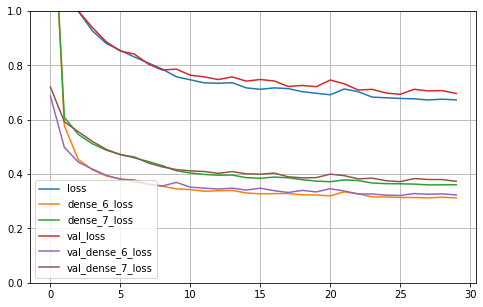

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8,5])
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [12]:
model.evaluate([x_test_scaled_wide,x_test_scaled_deep],
                       [y_test,y_test])

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8085233331650726, 0.37869775, 0.43166894]